# AE Model Evaluations -- Mainly Used For Debugging

In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import axis, colorbar, imshow, show, figure, subplot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
%matplotlib inline

import glob
import json

import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization, ReLU, LeakyReLU
from keras.models import Model
from keras.losses import binary_crossentropy, mse
from keras import backend as K                         #contains calls for tensor manipulations

Using TensorFlow backend.


In [2]:
print (tf.__version__)
print (keras.__version__)

2.1.0
2.3.1


In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
save_plots = False

# Define paths

In [5]:
from utils_ae_eval_paths import *

# What latent dimension and filter size are we using?:
latent_dim = 64

PATH = f'{potatodir}/saved_models'

# Get work direction for saving files:
TRAINED_MODELS = f'{PATH}/latent{latent_dim}'

# Load pre-traned model weights and other hyperparameters



### Load Images

In [6]:
print("[INFO] loading trained models and images...")

# load history from the trained model:
history = np.load(f'{TRAINED_MODELS}/HISTORY.npy', allow_pickle='TRUE').item()

# load training and testing images:
trainX   = np.load(f'{TRAINED_MODELS}/trainX.npy', allow_pickle='TRUE')       # training samples
valX     = np.load(f'{TRAINED_MODELS}/valX.npy', allow_pickle='TRUE')         # validation samples
testAllX = np.load(f'{TRAINED_MODELS}/testAllX.npy', allow_pickle='TRUE')     # all test samples
testAllY = np.load(f'{TRAINED_MODELS}/testAllY.npy', allow_pickle='TRUE')     # all test labels

print("          done")

[INFO] loading trained models and images...
          done


### Load Hyperparameters

In [7]:
txtfile = open(f'{TRAINED_MODELS}/notes.txt')

for line in txtfile:
    print(line)
    
# load some hyperparameters and data configurations automatic:
hyper_parameters = []
with open((f'{TRAINED_MODELS}/notes.txt'), 'r') as f:
    for l in f: 
        strnumbers = l.split(':')
        hyper_parameters.append(json.loads(strnumbers[1]))
        
no_epochs = hyper_parameters[0]
latent_dim = hyper_parameters[2]
img_width = hyper_parameters[4]
img_height = hyper_parameters[5]
num_channels = hyper_parameters[6]

Epochs: 1000 

Batch size: 256 

Latent dimension: 64 

Filter sizes: 32 

img_width: 128 

img_height: 128 

num_channels: 1


### Load VAE Architecture and its weights at final epoch

In [8]:
# improt architecture of encoder, decoder and VAE model:
from J64_AE_model import *

In [9]:
""" load the final weight for the Encoder part """
encoder.load_weights(f'{TRAINED_MODELS}/ENCODER_WEIGHTS.h5')

""" load the final weight for the VAE """
# Create a new model instance:
ae = create_model()
# Load the previously saved weights:
ae.load_weights(f'{TRAINED_MODELS}/AE_WEIGHTS.h5')

In [10]:
from utils_VAE_AE import subsplit, delete_rand_items, KITKAT_get_counts

testNormalX, testNormalY = subsplit(testAllX , testAllY, class_label=0)

# Evaluate model

## Further Inspections of Results


### Latent Space

Inspect Learned Latent Space

In [11]:
# remember to use all data (bad and good sample in same array)
data = (testAllX, testAllY)

In [12]:
sns.reset_defaults()

# =================
# Results visualization
# Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/ (François Chollet).
# Adapted to accomodate this VAE.
# =================
def viz_latent_space(encoder, data):
    input_data, target_data = data
    z = encoder.predict(input_data)
    
    labels = {0:   "normal",
              1:   "anomaly"} 
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
    sc = ax.scatter(z[:, 0], z[:, 1], c=target_data, alpha=0.4, cmap='viridis')
    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    
    cbar = plt.colorbar(sc, ticks = range(2))
    cbar.ax.set_yticklabels([labels.get(i) for i in range(2)])
    
    # produce a legend with the unique colors from the scatter
    #legend_ = ax.legend(*sc.legend_elements(),
    #                scatterpoints=3,
    #                loc="best", title="Classes")
    #ax.add_artist(legend_)
    
    plt.grid(False)
    plt.show()

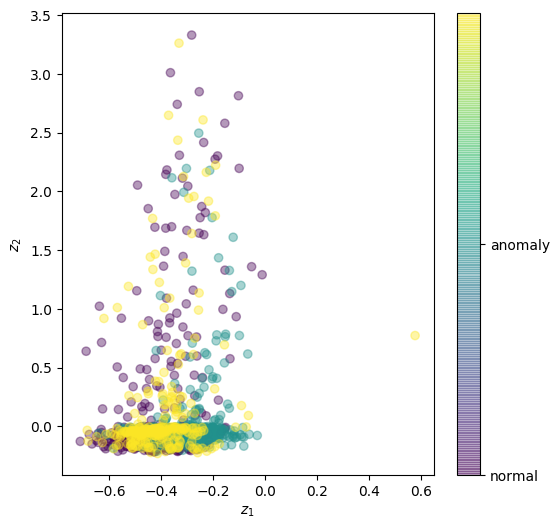

In [13]:
# display a 2D manifold plot of the digit classes in the latent space
viz_latent_space(encoder, data)

sns.set_style("darkgrid")

__Inspect variations__

Only normal test samples

In [14]:
testNormalEncodedX = encoder.predict(testNormalX)[2]
print (testNormalEncodedX.shape)

(64,)


#### Pair plot between normal and anomalies in latent space

From latent distribution

In [15]:
def pairplot_latent(encoder, data):
    # predict
    input_data, target_data = data
    z = encoder.predict(input_data)
    
    # convert to dataframe
    df = pd.DataFrame(z)
    
    latent_dims = []
    for i in range(len(z.T)):
        latent_dims.append(f'$z_{i+1}$')
    df.columns = latent_dims

    df.insert(0, "true_class", pd.DataFrame(target_data))
    df['true_class'] = df['true_class'].map({0:'normal', 1:'anomaly'})
    df['true_class']

    # drop some dimensions if latent dimension is larger than six..
    if len(df.columns) > 7:
        df.drop(df.iloc[:, 6:len(df.columns)], inplace=True, axis=1)

    # plot pairplot:
    sns.pairplot(df, hue="true_class", palette='viridis')
    plt.show()

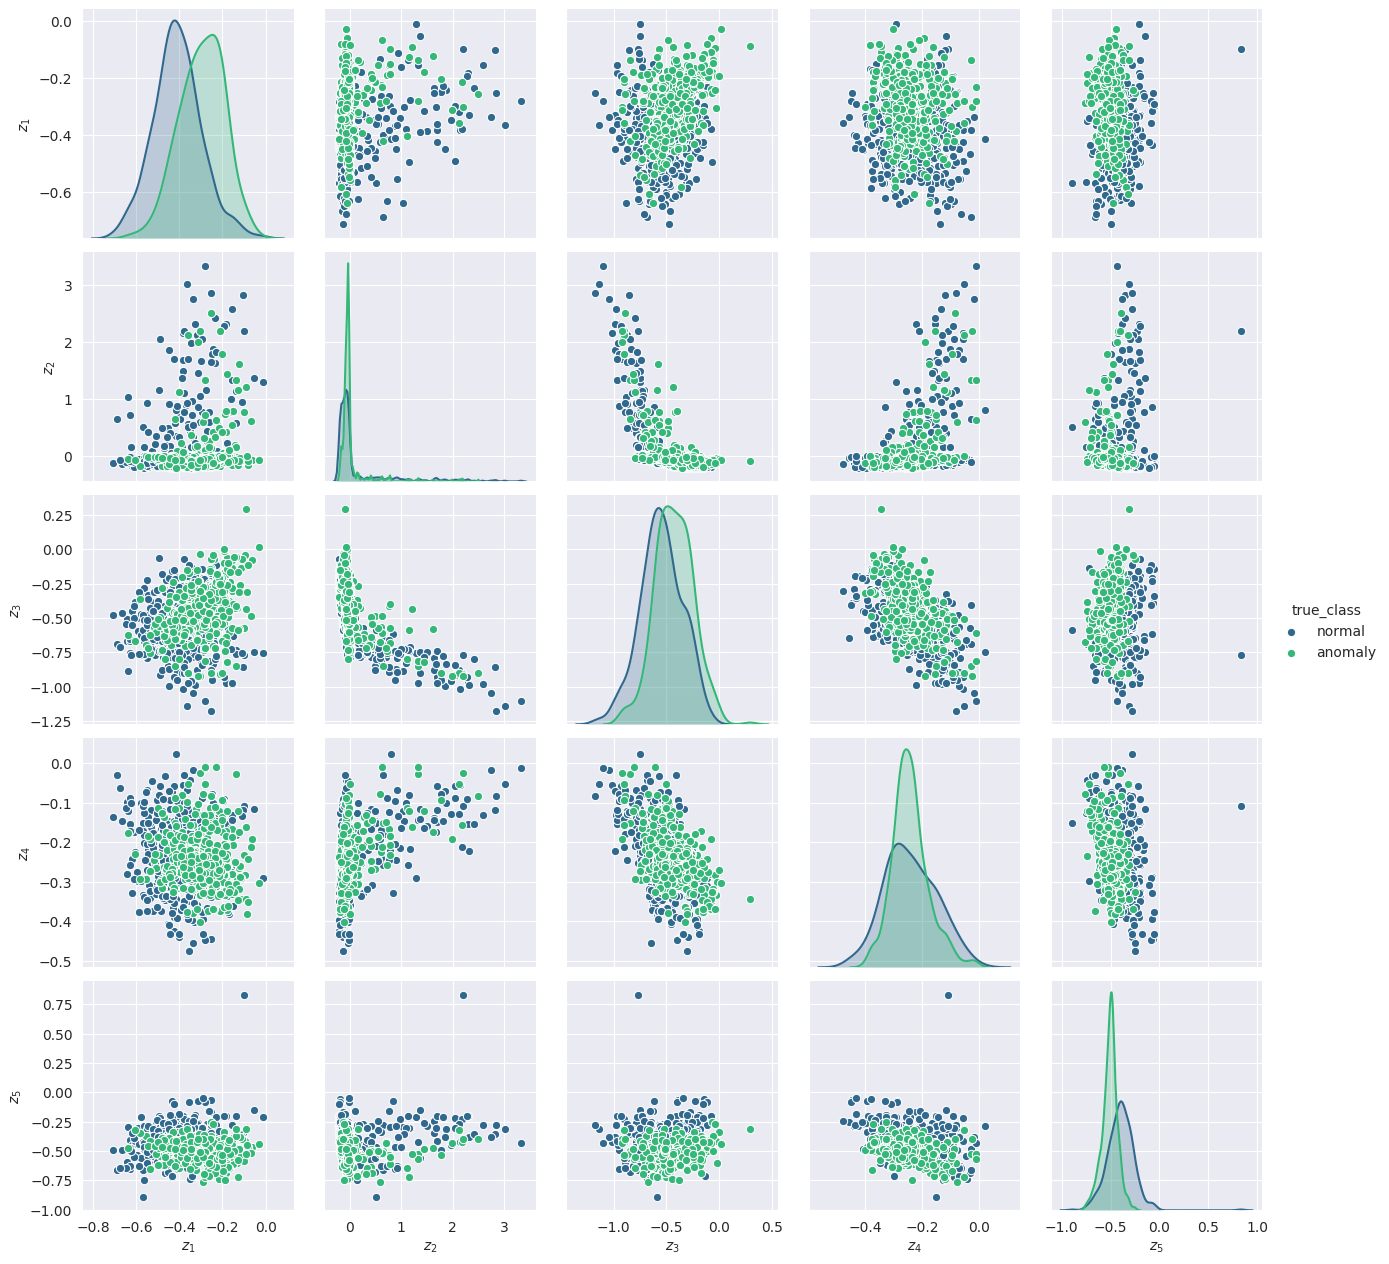

In [16]:
# display 2D manifold plots of the digit classes in the latent space (pairplot)
pairplot_latent(encoder, data)

### Encoder

#### Visualising Filters


In [17]:
# dictionary of the layers in the encoderm model; access the weights at each layer by the layer name:
layer_dict = dict([(layer.name, layer) for layer in encoder.layers])
#layer_dict

In [18]:
# summarize filter shapes in each convolutional layer:
idx = []
for i in range(len(encoder.layers)):
    layer = encoder.layers[i]
    
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    idx.append(i)
    
    # get filter weights
    filters, biases = layer.get_weights()
    
    # summarize output shape
    print(i, layer.name,  filters.shape)

1 conv2d_1 (2, 2, 1, 32)
4 conv2d_2 (2, 2, 32, 32)
7 conv2d_3 (2, 2, 32, 32)
10 conv2d_4 (2, 2, 32, 32)
13 conv2d_5 (2, 2, 32, 32)


1th convolution layer:


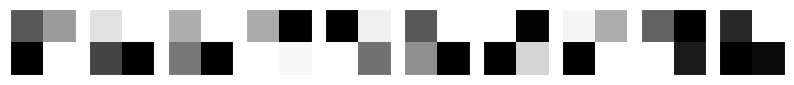

2th convolution layer:


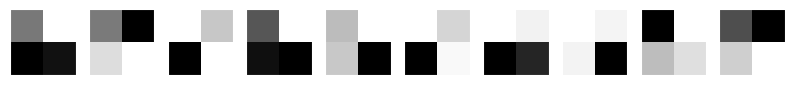

3th convolution layer:


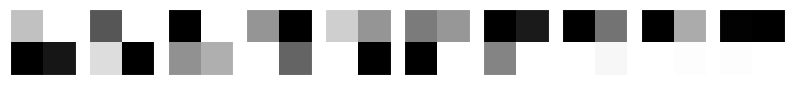

4th convolution layer:


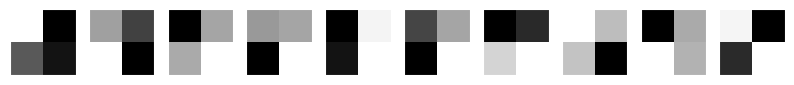

5th convolution layer:


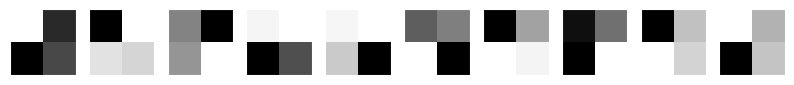

In [19]:
# normalize filter values to a range of 0 to 1 for better colormapping during plotting and visualization
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

# plot 10 filters from each convolution layers:
filtlayers = [1,2,3,4,5]
counter = 0
for i in range(len(idx)):
    # model.layers will print a list of layer parameters/values
    filters, biases = encoder.layers[idx[i]].get_weights()
    
    print('{}th convolution layer:'.format(filtlayers[counter]))
    fig, axs = plt.subplots(1,10, figsize=(10, 6))
    axs = axs.ravel()
    for i in range(10):
        axs[i].imshow(norm_filter(filters[:,:,0,i]), cmap=cm.Greys_r, vmin=0, vmax=1)
        axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
    plt.show()
    counter += 1

#### Visualising Feature Maps (Convolution Layers)

using training data

In [20]:
# summarize feature map size/shapes for each conv layer
idx = []
conv_names = []

for i in range(len(encoder.layers)):
    layer = encoder.layers[i]
    
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    idx.append(i)
    conv_names.append(layer.name)

    # summarize output shape
    print(i, layer.name, layer.output.shape)

1 conv2d_1 (None, 64, 64, 32)
4 conv2d_2 (None, 32, 32, 32)
7 conv2d_3 (None, 16, 16, 32)
10 conv2d_4 (None, 8, 8, 32)
13 conv2d_5 (None, 4, 4, 32)


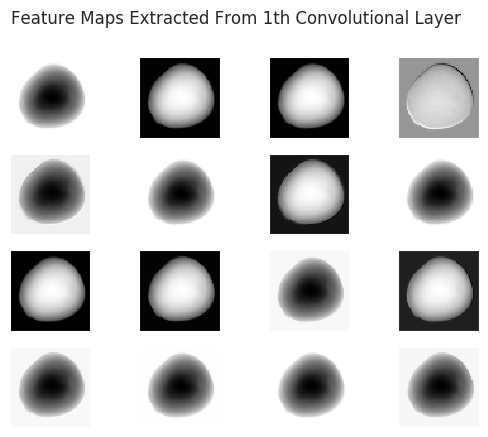

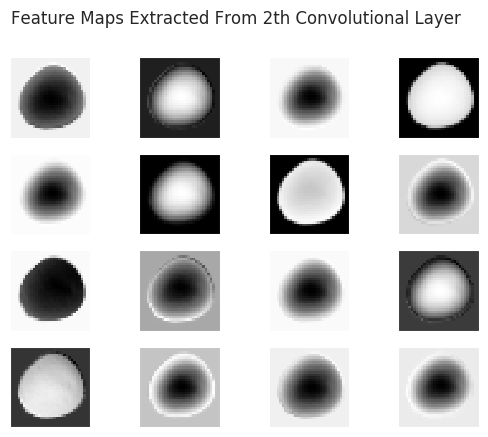

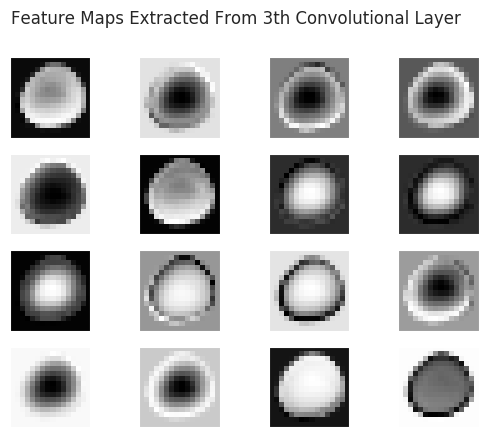

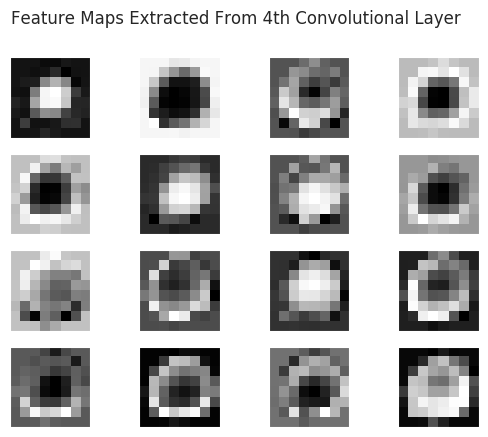

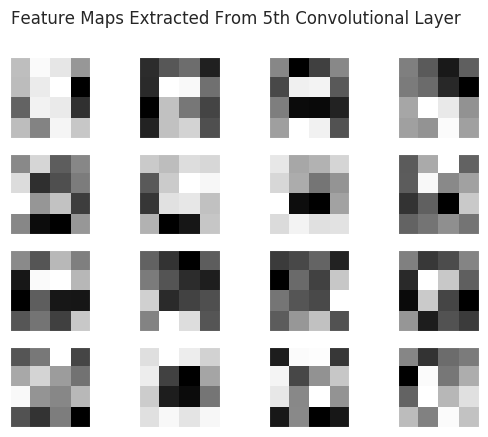

In [21]:
# redefine model to output all convolution layers:
conv_outputs = [encoder.layers[i].output for i in idx]        # convolutions
convolution_model = Model(inputs=encoder.inputs, outputs=conv_outputs)
#convolution_model.summary()

feature_maps = convolution_model.predict(np.expand_dims(trainX[0], axis=0))

# plot the output from each block
square = 4
convlayers = [1,2,3,4,5]     # used for titles..
counter = 0
for fmap in feature_maps:
    # plot 16 maps in an 4x4 squares
    ix = 1
    for i in range(square):
        for j in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            #plt.imshow(fmap[0, :, :, ix-1], cmap=cm.Greys_r, vmin=0, vmax=1)
            plt.imshow(fmap[0, :, :, ix-1], cmap=cm.Greys_r)  # "binary_r", 'viridis', 'plasma'
            ix += 1
    # show the figure
    plt.suptitle("Feature Maps Extracted From {}th Convolutional Layer".format(convlayers[counter]))
    #plt.tight_layout(pad=1, h_pad=0, w_pad=0)
    plt.show()
    counter += 1

#### Visualizing Intermediate Layer Activations (Activation Layers)

In [22]:
# summarize each activation layer:
adx = []
activ_names = []

for a in range(len(encoder.layers)):
    layer = encoder.layers[a]
    
    # check for convolutional layer
    if 'leaky_re_lu' not in layer.name:
        continue
    adx.append(a)
    activ_names.append(layer.name)

    # summarize output shape
    print(a, layer.name, layer.output.shape)

3 leaky_re_lu_1 (None, 64, 64, 32)
6 leaky_re_lu_2 (None, 32, 32, 32)
9 leaky_re_lu_3 (None, 16, 16, 32)
12 leaky_re_lu_4 (None, 8, 8, 32)
15 leaky_re_lu_5 (None, 4, 4, 32)
18 leaky_re_lu_6 (None, 64)


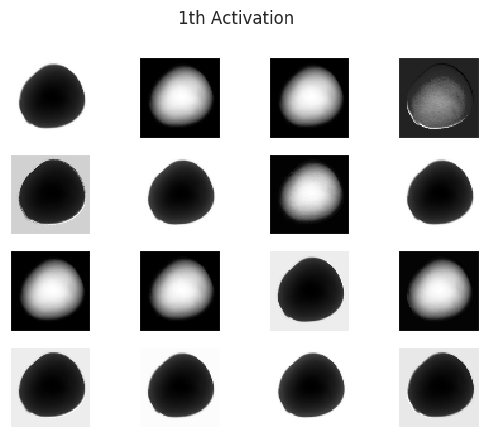

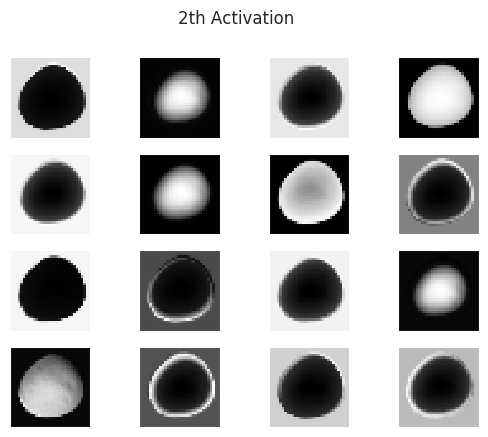

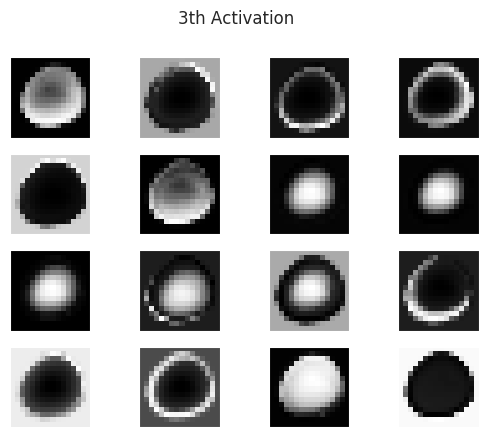

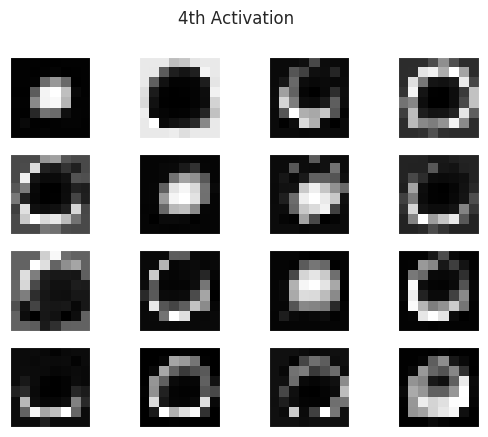

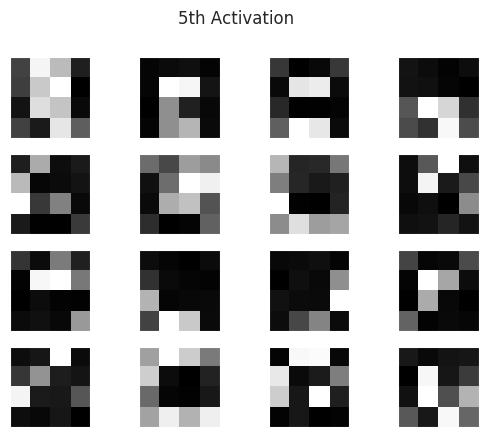

In [23]:
# redefine model to output all convolution layers:
activ_outputs = [encoder.layers[a].output for a in adx]       # activations
activation_model = Model(inputs=encoder.inputs, outputs=activ_outputs[:-1])
#activation_model.summary()

activations = activation_model.predict(np.expand_dims(trainX[0], axis=0)) #testGoodX[0]

# plot the output from each block
square = 4
actvlayers = [1,2,3,4,5]     # used for titles..
counter = 0
for fmap in activations:
    # plot 16 maps in an 4x4 squares
    ix = 1
    for i in range(square):
        for j in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(fmap[0, :, :, ix-1], cmap=cm.Greys_r)  # "binary_r", 'viridis', 'plasma'
            ix += 1
    # show the figure
    plt.suptitle("{}th Activation".format(actvlayers[counter]))
    #plt.tight_layout(pad=1, h_pad=0, w_pad=0)
    plt.show()
    counter += 1